# Notebook Overview : Longitudinal attention clustering
This notebook allows the identification of attention evolution's subtrends with **kmeans longitudinal clustering** 

It loads the data from the *Lisa* folder  \
It also uses the longitudinal clustering and cluster comparison functions from *Longitudinal_Clustering.py*

It contains : 
- Silhouette scores for up to 8 clusters (this number can be changed)
- Visual comparison from 2 to 4 clusters and for each, a comparison was done with the acute multi-domain clustering (T1)
- 3 was the chosen number of clusters to be saved in the *Longitudinal* folder

This notebook can be run for 2 different data sets : one with all language tests combined and the other one with only the LAST_score

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import Longitudinal_clustering as lc

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Important parameters to choose

In [2]:
# To choose the dataset
LAST_scores_no_language = True

#Nb of max clusters for the silhouette score
max_clusters = 8

domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
cluster_domain = "attention" # Domain on which we apply the clustering
n_domains = len(domains)
# colormap with unique colors for each label of Label_0 
colormap_label_0 = {"0": "blue", "1": "darkorange", "2": "red", "3": "green"}

# Import the 4 TiMeS datasets preprocessed and clustered by Aitana

In [3]:
root = r'../Data/Lisa/NMF_per_timepoint_merge_'
if LAST_scores_no_language:
    root = root + 'only_LAST_'

#Import the 4 TiMeS datasets, add time feature
NMF_1 = pd.read_csv(root+str(0)+'.csv').drop(columns=['Unnamed: 0']).assign(time="1").assign(time_in_weeks=1)
NMF_2 = pd.read_csv(root+str(1)+'.csv').drop(columns=['Unnamed: 0']).assign(time="2").assign(time_in_weeks=3)
NMF_3 = pd.read_csv(root+str(2)+'.csv').drop(columns=['Unnamed: 0']).assign(time="3").assign(time_in_weeks=12) #12 weeks = 3 months
NMF_4 = pd.read_csv(root+str(3)+'.csv').drop(columns=['Unnamed: 0']).assign(time="4").assign(time_in_weeks=52) #52 weeks = 1 year

#Merge the 4 TiMeS datasets in one
NMF = pd.concat([NMF_1, NMF_2, NMF_3, NMF_4])

#Change label column type for statistics purposes
NMF['Labels'] = NMF['Labels'].astype(str)

## Preprocessing

In [4]:
# Add feature of the first timepoint label to the NMF dataframe
NMF["Label_0"] = NMF.apply(lambda x: NMF_1[NMF_1["Patient"]==x["Patient"]]["Labels"].values[0].astype(str) if any(NMF_1["Patient"]==x["Patient"]) else np.nan, axis=1)

# Remove patients that have only one timepoint
NMF_new = NMF.groupby('Patient').filter(lambda x: len(x) > 1)
useless = NMF_new.groupby('Patient').filter(lambda x: len(x) <= 2)
display(useless)
print(useless.shape)


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0
4,0.014486,0.314425,0.337978,0.000000,0.0,0.078781,P005,0,1,1,0
8,0.044361,0.473566,0.544241,0.216216,1.0,0.208320,P009,1,1,1,1
20,0.054273,0.193072,0.321026,0.000000,0.0,0.136203,P022,0,1,1,0
28,0.048080,0.374975,0.464582,0.021739,0.1,0.078320,P032,1,1,1,1
31,0.616390,0.379135,0.386879,0.105466,0.0,0.065383,P035,2,1,1,2
39,0.032881,0.461549,0.414228,0.000000,0.0,0.066077,P043,1,1,1,1
43,0.021162,0.215157,0.233353,0.043478,0.0,0.026893,P047,0,1,1,0
47,0.058081,0.261577,0.406461,0.021739,0.0,0.163686,P053,0,1,1,0
49,0.703592,0.476206,0.566184,0.159634,0.1,0.166058,P056,3,1,1,3
52,0.028441,0.260944,0.397031,0.000000,0.0,0.044572,P059,0,1,1,0


(28, 11)


# Longitudinal Clustering with kmeans and Dynamic Time Warping

* As we have a dataset with a relatively small sample size, **kmeans** seemed to be a good clustering algorithm

* As the data time series have different length and do not start at the same time, euclidian distance cannot be computed for kmeans. \
By using **Dynamic Time Warping**, we develop a one to many match, and thus we can find an optimal alignment between two time series of different lengths \
With DBA (DTW barycenter averaging), multiple time series can be averaged https://www.sciencedirect.com/science/article/pii/S003132031000453X

Problem remaining : Preserve the exact temporal relationships in the data, should we interpolate ?


## Visualize Silhouette scores to choose the number of clusters

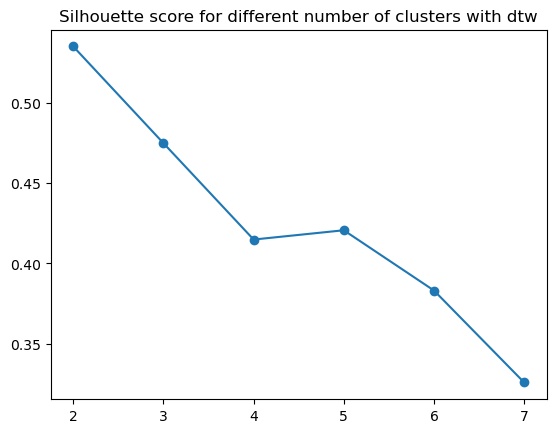

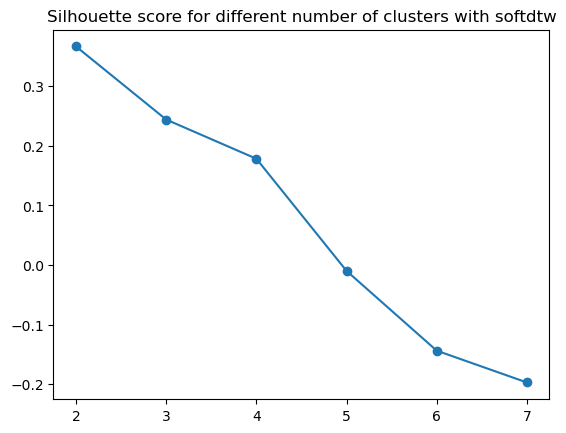

In [5]:
#get data in right format for clustering
data, df_data= lc.get_time_series(NMF_new, cluster_domain)

#Choosing the number of clusters with the dtw metric
metric="dtw"
lc.choose_n_clusters(data, max_clusters, metric)

#Choosing the right number of clusters with the softdtw metric
metric="softdtw"
lc.choose_n_clusters(data, max_clusters, metric)

According to the silhouette score, the optimal number of clusters is 0.

## Visual comparison from 2 to 4 clusters 

### With 2 clusters

In [6]:
#Clustering
n_clusters=2
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list, domain=cluster_domain)
display(NMF_new)


[1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0
 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0]
[0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1
 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_attention_labels
0,0.003716,0.194499,0.295743,0.000000,0.0,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.1,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.0,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.0,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.0,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.0,0.132609,P079,1,2,3,NaN,1
217,0.033269,0.396613,0.435969,0.000000,0.0,0.148478,P079,1,3,12,NaN,1
218,0.031642,0.429661,0.407130,0.000000,0.1,0.088666,P079,1,4,52,NaN,1
219,0.085931,0.333692,0.386517,0.014127,0.0,0.038064,P052,0,3,12,NaN,0


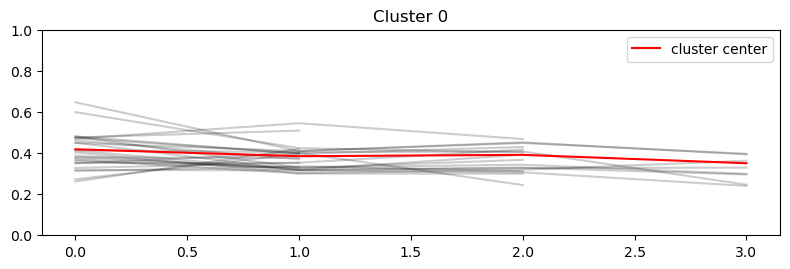

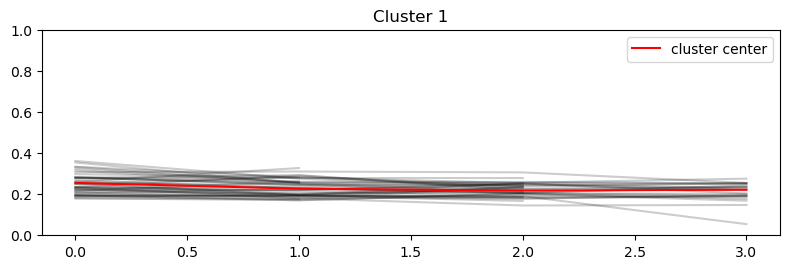

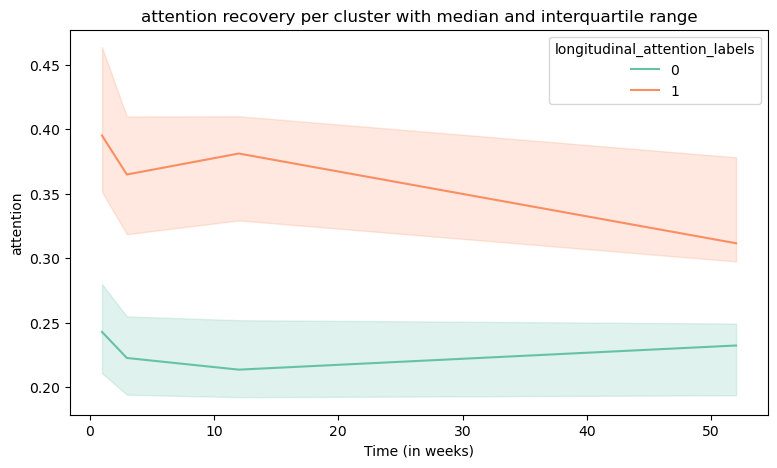

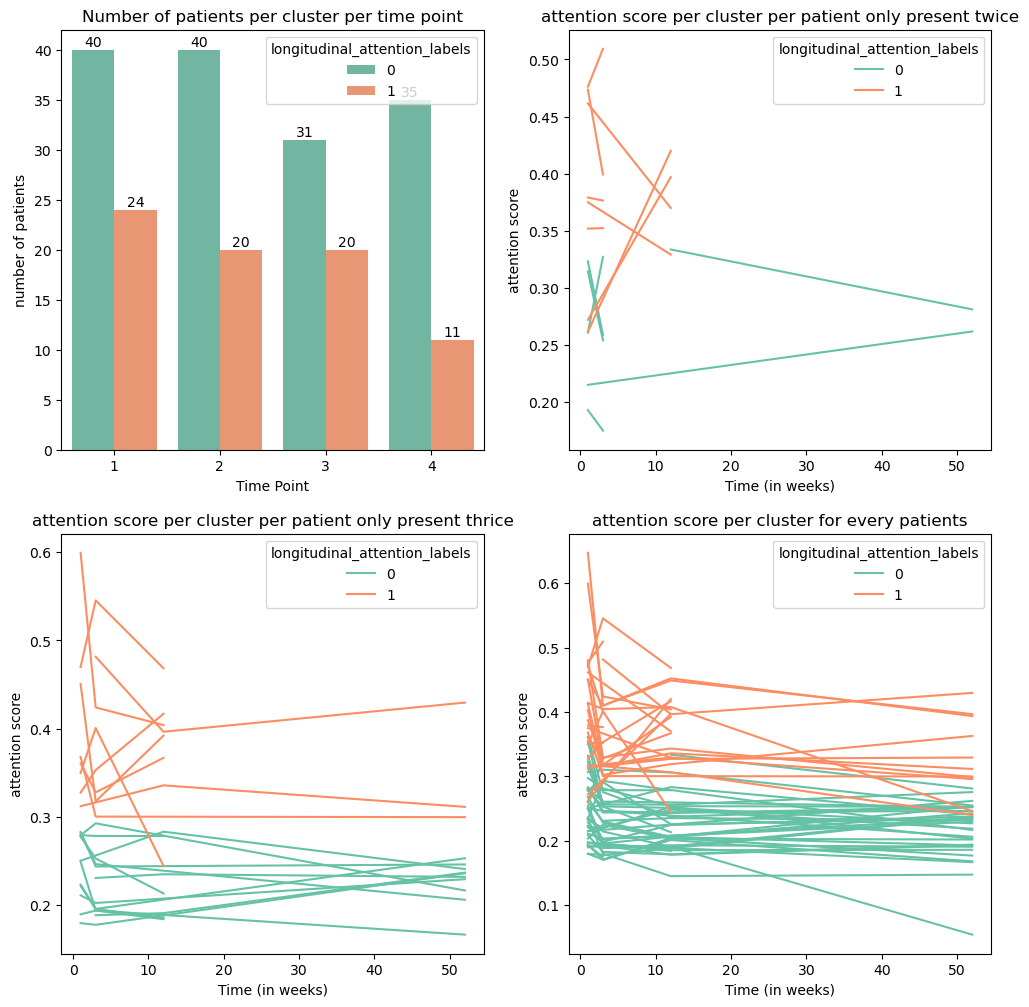

In [7]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new,cluster_domain)

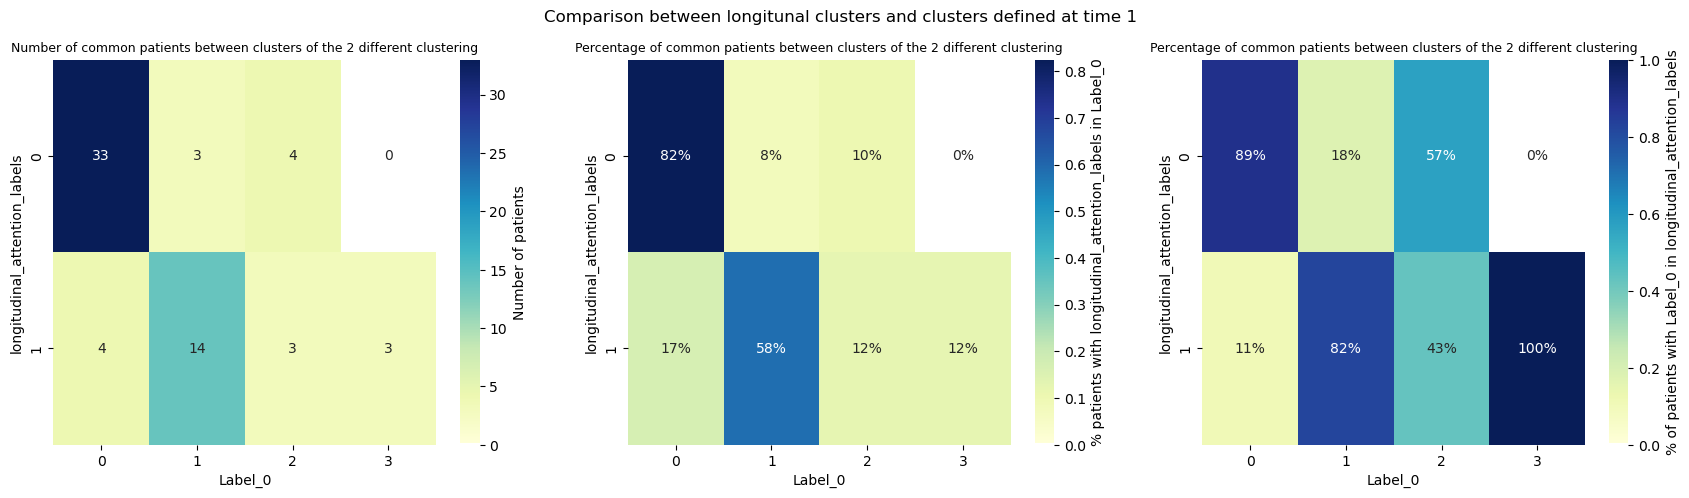

In [8]:
#Comparison between clusters at time 1 and longitudinal clusters (Acute Multi-Domain cluster vs longitudinal attemtion cluster)
lc.comparison2(NMF_new, "longitudinal_attention_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 1")

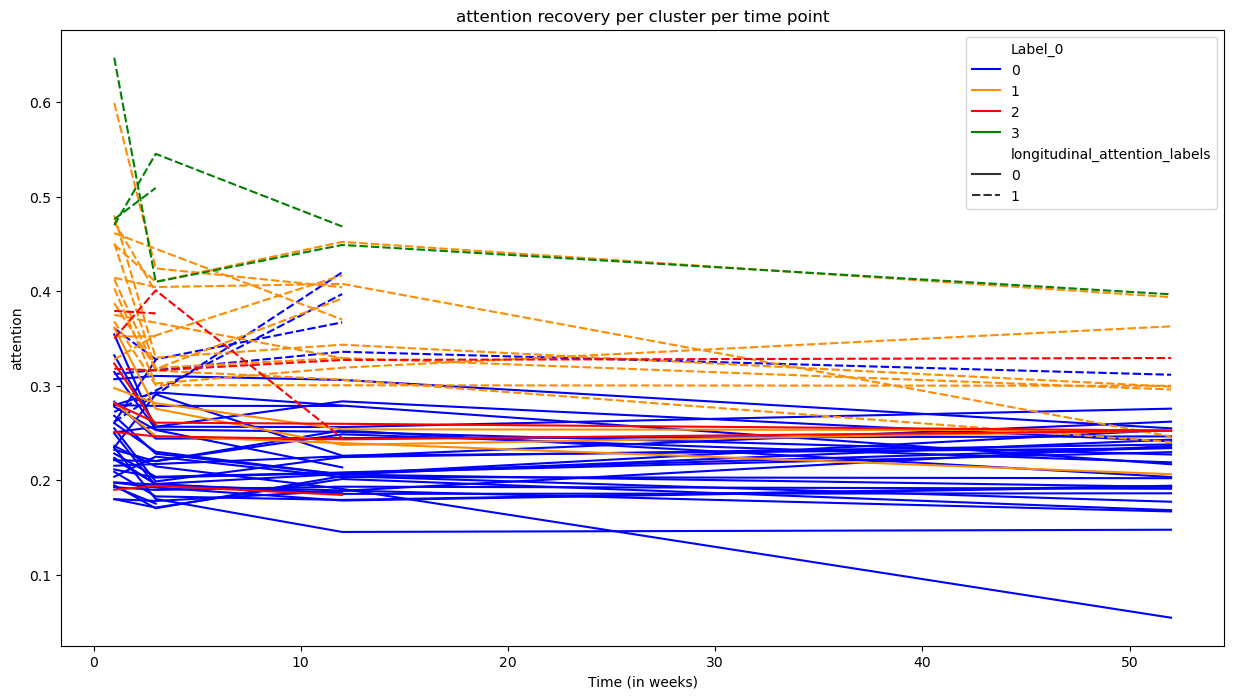

In [9]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_attention_labels", colormap_label_0, cluster_domain)

### With 3 clusters

In [10]:
#Clustering
n_clusters=3
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list, cluster_domain)
display(NMF_new)


[1 1 1 1 2 2 2 0 0 1 2 1 1 1 1 1 1 2 1 1 1 0 1 1 1 2 2 1 2 2 2 2 2 1 2 1 0
 1 1 1 2 2 2 2 0 0 1 2 1 1 2 1 2 2 1 1 2 2 1 0 1 2 2 0 0 1 1 2]
[0 0 0 0 1 1 1 2 2 0 1 0 0 0 0 0 0 1 0 0 0 2 0 0 0 1 1 0 1 1 1 1 1 0 1 0 2
 0 0 0 1 1 1 1 2 2 0 1 0 0 1 0 1 1 0 0 1 1 0 2 0 1 1 2 2 0 0 1]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_attention_labels
0,0.003716,0.194499,0.295743,0.000000,0.0,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.1,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.0,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.0,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.0,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.0,0.132609,P079,1,2,3,NaN,2
217,0.033269,0.396613,0.435969,0.000000,0.0,0.148478,P079,1,3,12,NaN,2
218,0.031642,0.429661,0.407130,0.000000,0.1,0.088666,P079,1,4,52,NaN,2
219,0.085931,0.333692,0.386517,0.014127,0.0,0.038064,P052,0,3,12,NaN,1


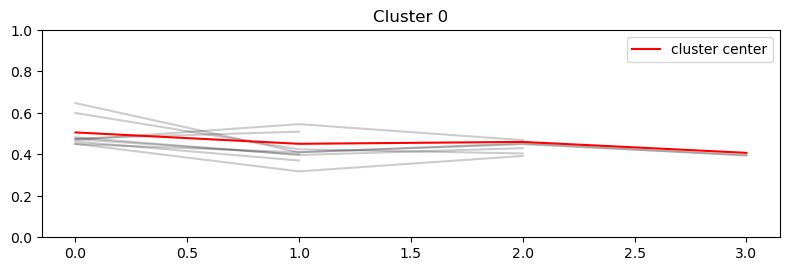

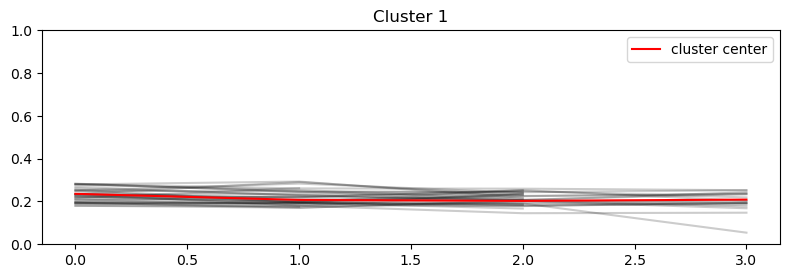

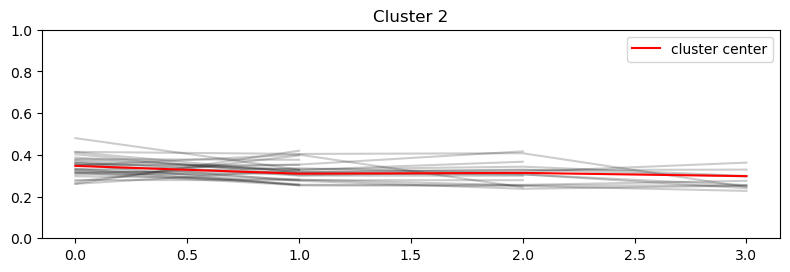

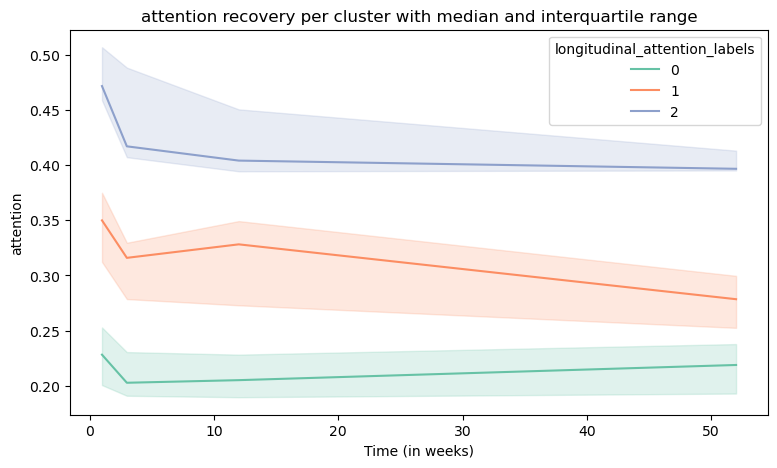

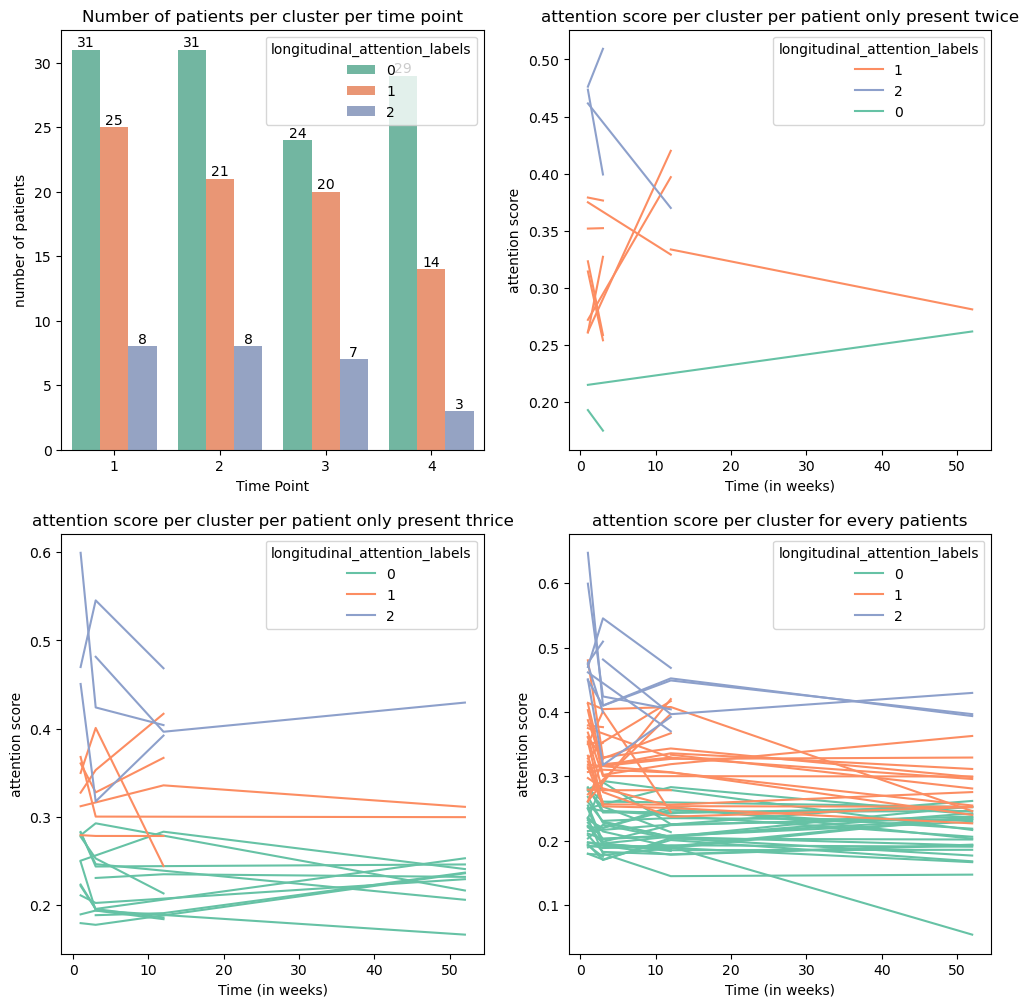

In [11]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new, cluster_domain)

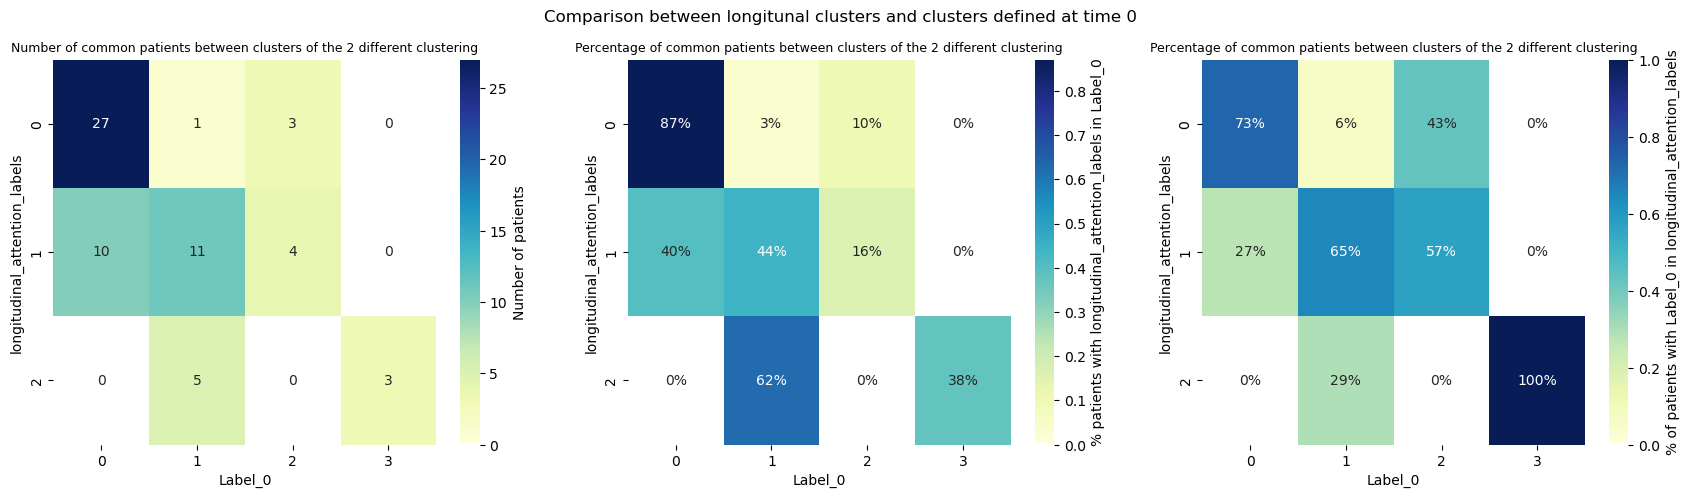

In [12]:
lc.comparison2(NMF_new, "longitudinal_attention_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 0")

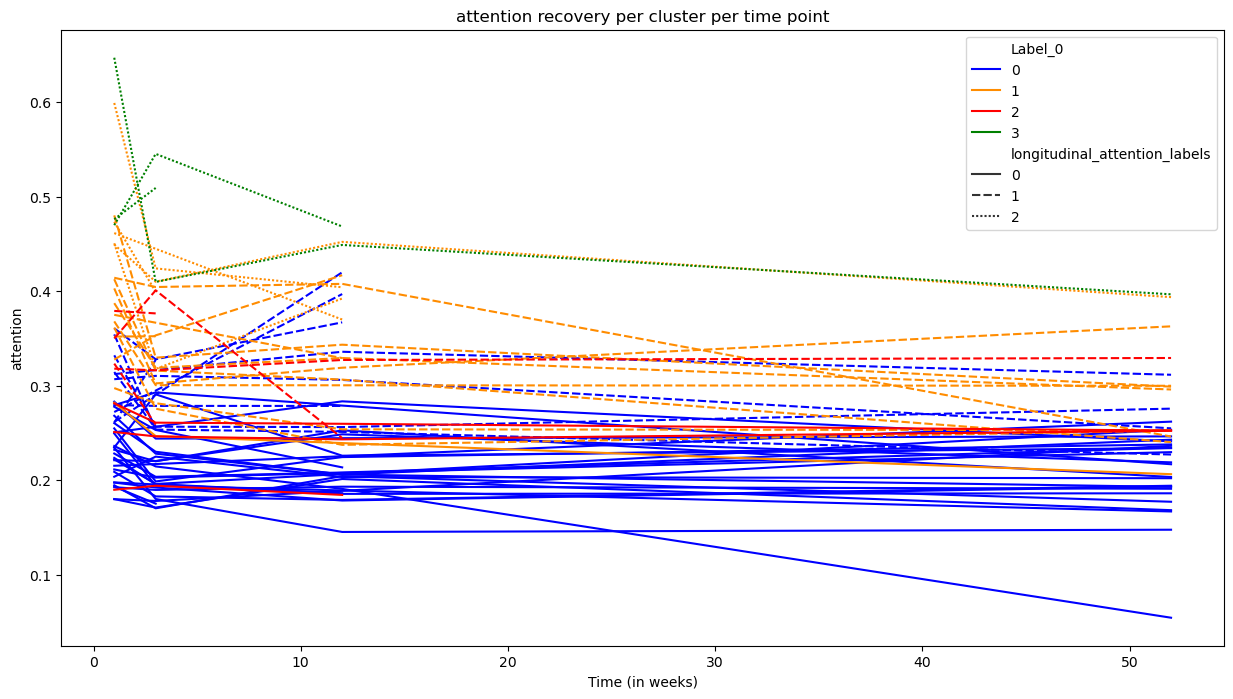

In [13]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_attention_labels", colormap_label_0, cluster_domain)

/home/constance/Documents/epfl/CRR project/TiMeS_WP11/Code/Longitudinal_clustering.py:209: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=NMF, x="time_in_weeks", y=domain, hue=label0, style=label1, palette=palette, estimator =None, units="Patient")


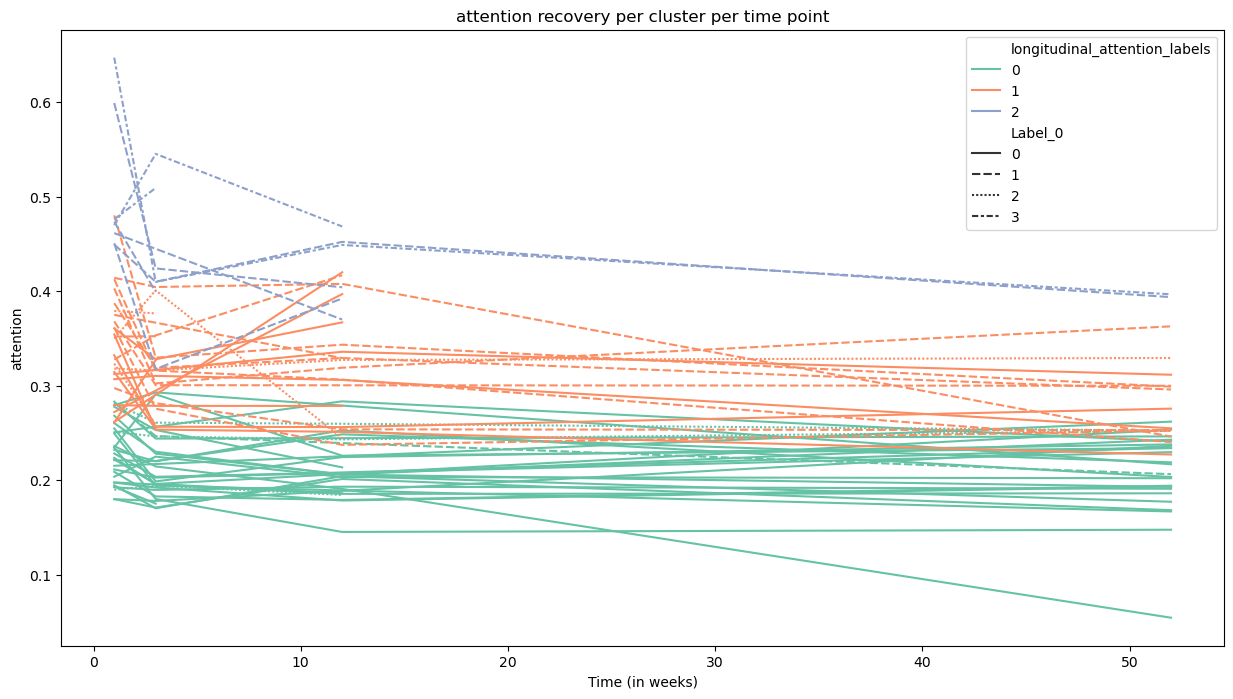

In [14]:
lc.lineplot_comparison(NMF_new, "longitudinal_attention_labels", "Label_0", sns.color_palette('Set2'), cluster_domain)

### With 4 clusters

In [15]:
#Clustering
n_clusters=4
metric="dtw"
labels, km = lc.kmeans_clustering(data, n_clusters, metric)

# Sorting the cluster labels based on the number of points they contain
ordered_labels_list = lc.order_clusters(data, labels)

#Add labels to the original dataframe
NMF_new = lc.add_labels_to_NMF(df_data, NMF_new, ordered_labels_list,cluster_domain)
display(NMF_new)

[1 1 1 1 2 2 3 3 3 1 2 1 1 1 1 1 1 2 1 1 1 3 2 1 1 2 2 1 3 2 2 2 2 1 2 1 3
 2 1 1 2 2 2 2 0 3 1 2 1 1 2 1 2 3 1 1 2 2 1 3 1 2 3 0 3 1 1 2]
[0 0 0 0 1 1 2 2 2 0 1 0 0 0 0 0 0 1 0 0 0 2 1 0 0 1 1 0 2 1 1 1 1 0 1 0 2
 1 0 0 1 1 1 1 3 2 0 1 0 0 1 0 1 2 0 0 1 1 0 2 0 1 2 3 2 0 0 1]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,longitudinal_attention_labels
0,0.003716,0.194499,0.295743,0.000000,0.0,0.056766,P001,0,1,1,0,0
1,0.003425,0.170126,0.328080,0.000000,0.1,0.047076,P001,0,2,3,0,0
2,0.003898,0.204180,0.213347,0.010526,0.0,0.017072,P001,0,3,12,0,0
3,0.003055,0.177056,0.248852,0.000000,0.0,0.014714,P001,0,4,52,0,0
4,0.036073,0.179785,0.332524,0.000000,0.0,0.037255,P002,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.047187,0.481552,0.412853,0.000000,0.0,0.132609,P079,1,2,3,NaN,2
217,0.033269,0.396613,0.435969,0.000000,0.0,0.148478,P079,1,3,12,NaN,2
218,0.031642,0.429661,0.407130,0.000000,0.1,0.088666,P079,1,4,52,NaN,2
219,0.085931,0.333692,0.386517,0.014127,0.0,0.038064,P052,0,3,12,NaN,1


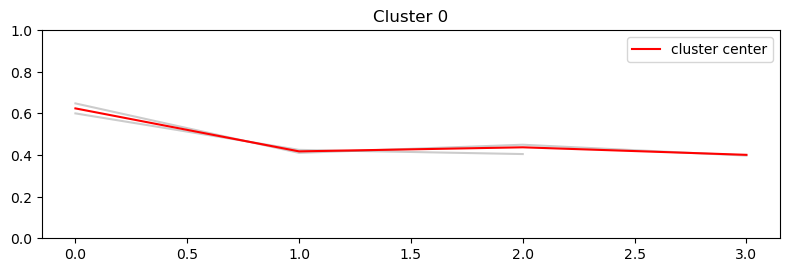

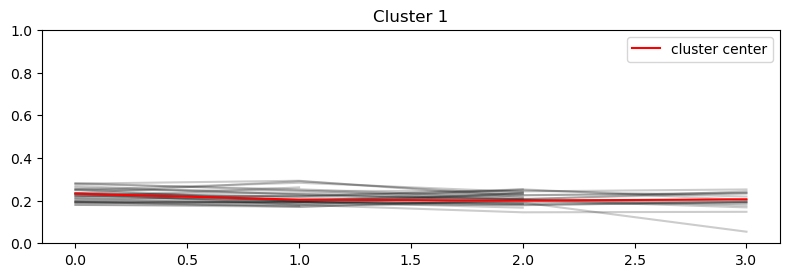

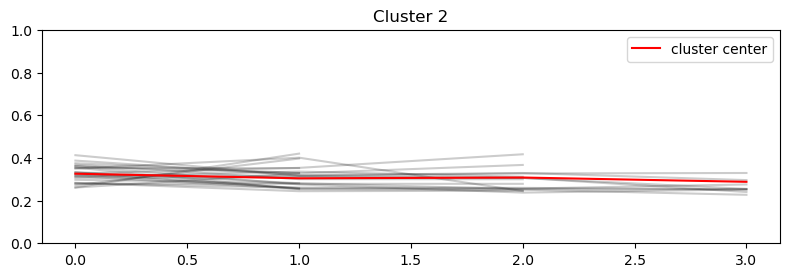

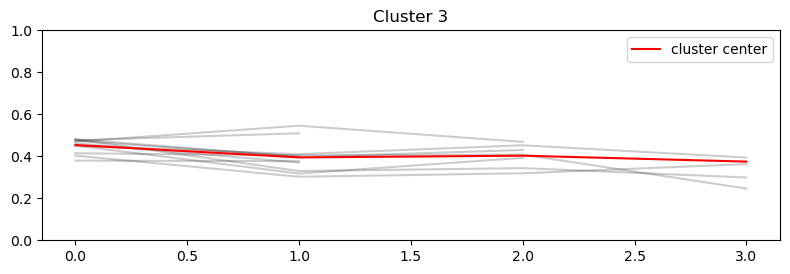

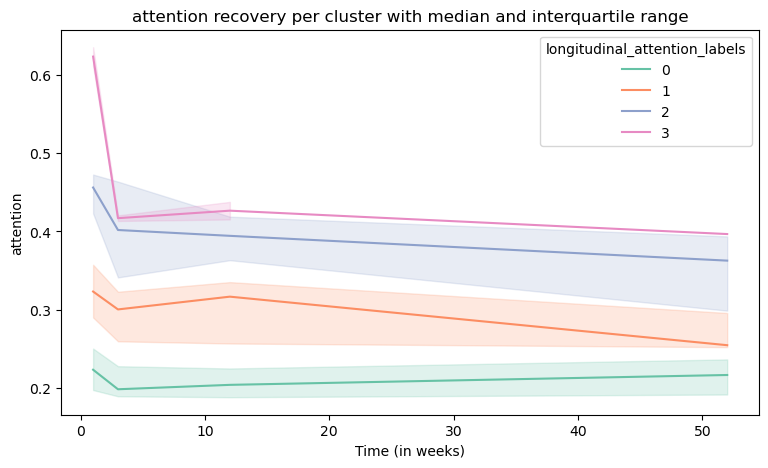

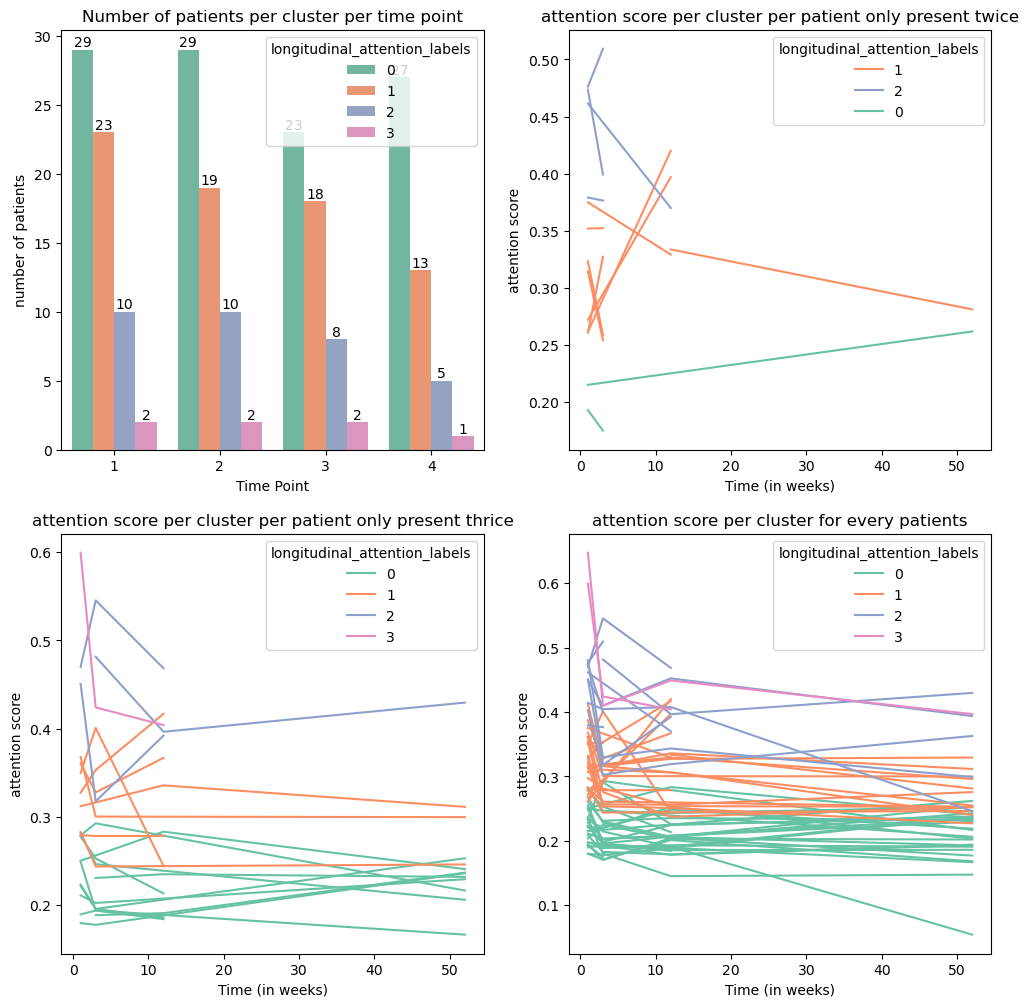

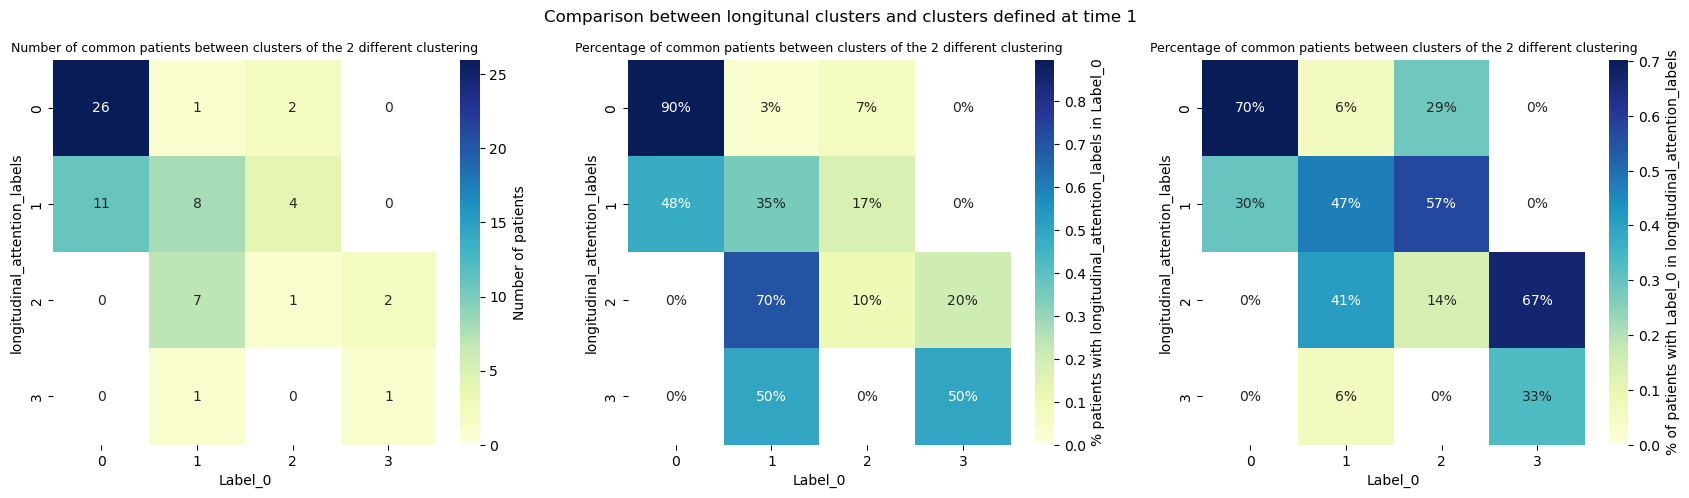

In [16]:
#Visualization
lc.plot_clusters(n_clusters, data, labels, km)
lc.clusters_info(NMF_new, cluster_domain)
lc.comparison2(NMF_new, "longitudinal_attention_labels", "Label_0", "Comparison between longitunal clusters and clusters defined at time 1")

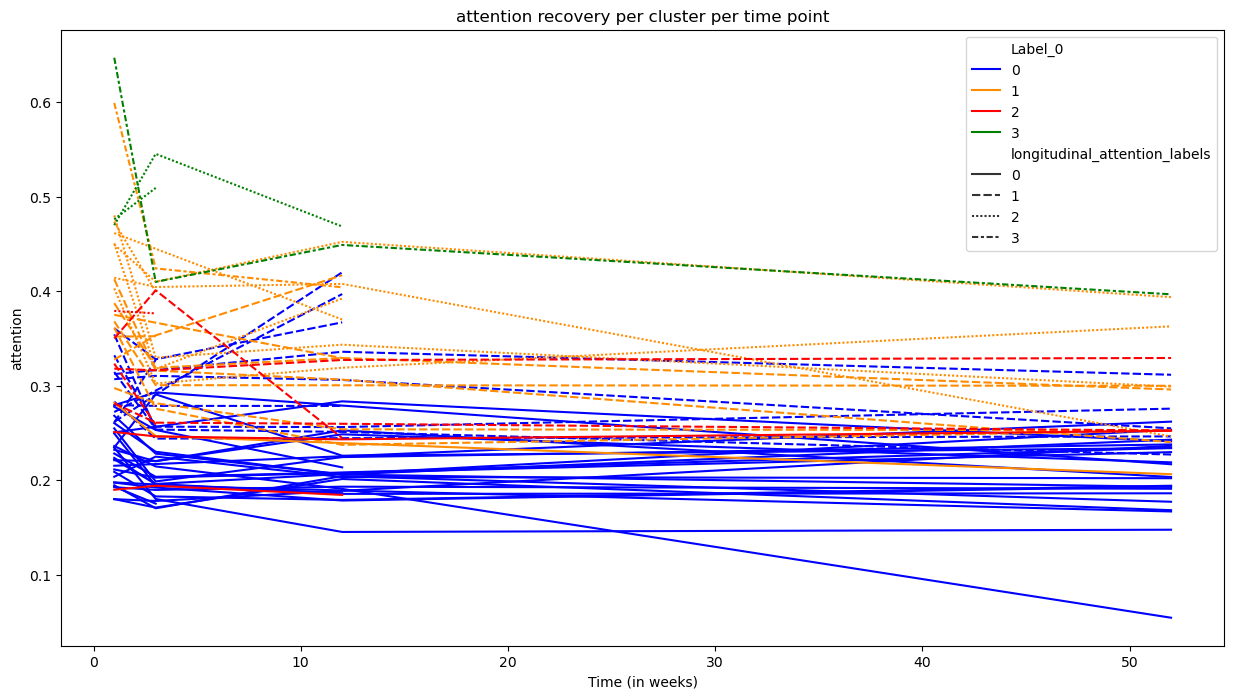

In [17]:
lc.lineplot_comparison(NMF_new, "Label_0", "longitudinal_attention_labels", colormap_label_0, cluster_domain)